In [1]:
!pip install tqdm
!pip install tqdm --upgrade

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.48.2)


## Librerías

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np

# TESORFLOW
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, SGD
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from IPython.display import Image

from tqdm.keras import TqdmCallback

In [3]:
print(tf.__version__)

2.3.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

!unzip '/content/drive/My Drive/Máster KSchool/TFM/data/filtered_img.zip'

Streaming output truncated to the last 5000 lines.
  inflating: filtered_img/tt0246262.png  
  inflating: filtered_img/tt0269281.png  
  inflating: filtered_img/tt0011396.png  
  inflating: filtered_img/tt0078320.png  
  inflating: filtered_img/tt0389361.png  
  inflating: filtered_img/tt0092921.png  
  inflating: filtered_img/tt0115682.png  
  inflating: filtered_img/tt0029609.png  
  inflating: filtered_img/tt0123330.png  
  inflating: filtered_img/tt2006093.png  
  inflating: filtered_img/tt0061671.png  
  inflating: filtered_img/tt0953903.png  
  inflating: filtered_img/tt0322082.png  
  inflating: filtered_img/tt0028517.png  
  inflating: filtered_img/tt4799672.png  
  inflating: filtered_img/tt1305714.png  
  inflating: filtered_img/tt0284137.png  
  inflating: filtered_img/tt0201129.png  
  inflating: filtered_img/tt0038704.png  
  inflating: filtered_img/tt3163244.png  
  inflating: filtered_img/tt0227850.png  
  inflating: filtered_img/tt4799114.png  
  inflating: filtered_img

## Importar datos

In [6]:
data_tab = pd.read_csv('/content/drive/My Drive/Máster KSchool/TFM/data/filtered_df_with_imgNames.csv',sep=',',header= 0,usecols=['CODE','RATING'])
data_tab = data_tab.apply(lambda x: x.str.replace(',','.'))

In [7]:
data_tab.head(3)

,CODE,RATING
0,tt4686108.png,5.3
1,tt0445033.png,6.4
2,tt1167599.png,5.5


Categorizamos la columna Rating


In [8]:
data_tab['RATING']  = data_tab['RATING'].astype(float)
data_tab['RATING'] = pd.cut( data_tab['RATING'], bins = [0,5, 6.5,10], labels=['1','2','3'])
data_tab.head(3)

,CODE,RATING
0,tt4686108.png,2
1,tt0445033.png,2
2,tt1167599.png,2


In [9]:
print(len(data_tab[data_tab['RATING']=='2']))
print(len(data_tab[data_tab['RATING']=='1']))
print(len(data_tab[data_tab['RATING']=='0']))

47141
19770
0


Image data generator

In [10]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
                        dataframe=data_tab,
                        directory="filtered_img/",
                        x_col="CODE",
                        y_col="RATING",
                        subset="training",
                        batch_size=300,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(134, 91))
valid_generator=datagen.flow_from_dataframe(
                        dataframe=data_tab,
                        directory="filtered_img/",
                        x_col="CODE",
                        y_col="RATING",
                        subset="validation",
                        batch_size=300,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        target_size=(134,91))

Found 80386 validated image filenames belonging to 3 classes.
Found 26795 validated image filenames belonging to 3 classes.


## Paramentros para el entrenamiento

In [11]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

epochs = 100

## Creamos y entrenamos el modelo

In [12]:
input_tensor = tf.keras.layers.Input((134,91,3))
base_model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)


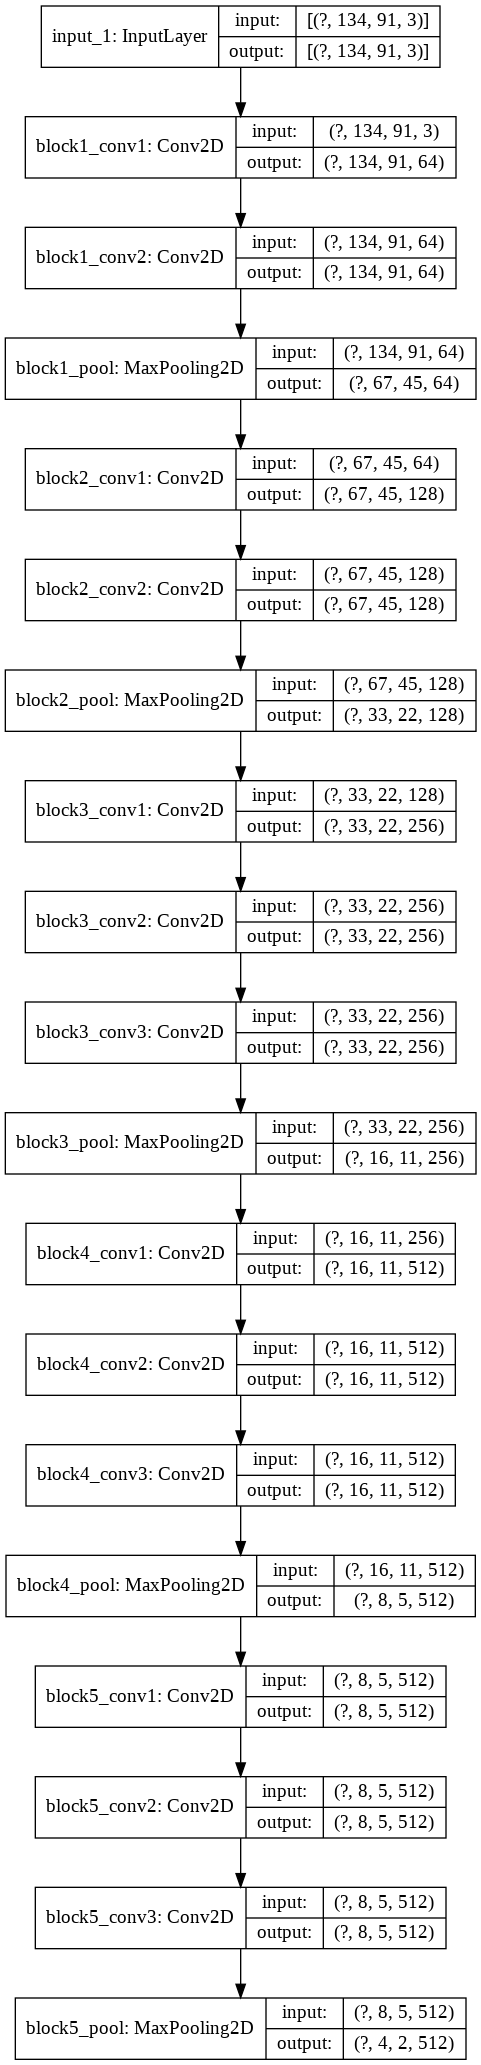

In [13]:
plot_model(base_model, to_file='model3.png',show_shapes=True,show_layer_names=True)
Image(retina=True, filename='model3.png')

In [14]:
base_model.layers

In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 134, 91, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 134, 91, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 134, 91, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 67, 45, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 67, 45, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 67, 45, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 33, 22, 128)       0     

In [16]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/Máster KSchool/TFM/Codigos/Img classification/IMG_Clasiffier-VGG16-Best_model_weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='min', period=1)

# Creamos el modelo base sobre el que vamos a hacer fine tunning
input_tensor = tf.keras.layers.Input((134,91,3))
base_model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

# Creamos el clasificador
x = base_model.output

x = GlobalAveragePooling2D()(x)
'''x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)'''

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.8)(x)
x = tf.keras.layers.Dense(16,activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.8)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# first: Entrenamos solo las capas del clasificador y congelamos las demas capas del modelo pretrained
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])

# train the model on the new data for a few epochs
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,callbacks=[TqdmCallback()], verbose=2)

'''# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:10]:
   layer.trainable = False
for layer in model.layers[10:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=["accuracy"])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,callbacks=[TqdmCallback(),checkpoint], verbose=2)'''

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
267/267 - 165s - loss: 1.5507 - accuracy: 0.3793 - val_loss: 1.0394 - val_accuracy: 0.4422
Epoch 2/100
267/267 - 158s - loss: 1.0627 - accuracy: 0.4350 - val_loss: 1.0343 - val_accuracy: 0.4411
Epoch 3/100
267/267 - 156s - loss: 1.0393 - accuracy: 0.4400 - val_loss: 1.0319 - val_accuracy: 0.4424
Epoch 4/100
267/267 - 156s - loss: 1.0377 - accuracy: 0.4418 - val_loss: 1.0296 - val_accuracy: 0.4471
Epoch 5/100
267/267 - 156s - loss: 1.0367 - accuracy: 0.4433 - val_loss: 1.0291 - val_accuracy: 0.4475
Epoch 6/100
267/267 - 156s - loss: 1.0357 - accuracy: 0.4434 - val_loss: 1.0271 - val_accuracy: 0.4523
Epoch 7/100
267/267 - 158s - loss: 1.0357 - accuracy: 0.4449 - val_loss: 1.0280 - val_accuracy: 0.4483
Epoch 8/100
267/267 - 157s - loss: 1.0354 - accuracy: 0.4449 - val_loss: 1.0270 - val_accuracy: 0.4502
Epoch 9/100
267/267 - 156s - loss: 1.0354 - accuracy: 0.4452 - val_loss: 1.0270 - val_accuracy: 0.45

KeyboardInterrupt: ignored

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
!nvidia-smi